# EMD applied to three-component signals

Corresponds to the results in Chapter 4.3. We build signals with three components and apply EMD. We vary the ratios between the frequencies.

## Produces Figures 19, 20, 21

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import scipy.stats as stats
import sys
import time
import PyEMD

from scipy.io import loadmat
from scipy.signal import hilbert, chirp, find_peaks_cwt
from scipy import fftpack

### Set up and run simulation

In [2]:
""" 
===============================================================================================
                                    PARAMETER DEFINITIONS
===============================================================================================
"""
np.random.seed(1)                          # set seed for reproducibility
n_trials = 1                               # number of trials

# COMPONENT PARAMETERS --------------------------------------------------------------------
max_amp = 1000.                            # maximum amplitude of signal component
nF = 3                                     # number of frequency components
p = np.random.uniform(low=0.0,             # phase offsets for components
                      high=2*np.pi,
                      size=nF)

# FREQUENCIES OF COMPONENTS --------------------------------------------------------------
n_f_2_steps = 60 #40                         # number of frequency increments
n_f_3_steps = 60 #30                         # number of frequency increments
ratios_12 = np.linspace(start=1.0,            # ratio of riding wave to carrier wave
                        stop=10, 
                        num=n_f_2_steps)

ratios_23 = np.linspace(start=1.0,  # 1.5           # ratio of riding wave to carrier wave
                        stop=10, 
                        num=n_f_3_steps)
f_1 = 8                                    # frequency of carrier wave, scalar (8 Hz theta)
F = np.zeros((n_f_2_steps, 
              n_f_3_steps, 
              nF))                         # List to contain each increment
for k in range(n_f_2_steps):               # build the list
    for l in range(n_f_3_steps):
        F[k,l,:] = [f_1, 
                    np.round(f_1*ratios_12[k], 2),
                    np.round(f_1*ratios_12[k]*ratios_23[l], 2)]

# SAMPLE RATES ----------------------------------------------------------------------------
n_sample_rates = 1                         # number of increments
fs = 15000

# SIGNAL LENGTHS --------------------------------------------------------------------------
n_lengths = 1 #40                          # number of signal lengths (defines increment)
cycle_length = 1/f_1                       # one cycle of slowest component
max_cycles = 30                            # max number of cycles
nS = max_cycles * cycle_length             # length in seconds

# STORE RESULTS ---------------------------------------------------------------------------
# initialize matrix to store correlations
C_all = np.empty(shape=(n_f_2_steps, n_f_3_steps, nF, nF))     
IF_all = np.empty(shape=(n_f_2_steps, n_f_3_steps, nF)) 
IA_all = np.empty(shape=(n_f_2_steps, n_f_3_steps, nF)) 
IF_nb_all = np.empty(shape=(n_f_2_steps, n_f_3_steps, nF)) 
IA_nb_all = np.empty(shape=(n_f_2_steps, n_f_3_steps, nF))

inst_freq_all = np.empty(shape=(n_f_2_steps, n_f_3_steps, nF))
inst_amp_all = np.empty(shape=(n_f_2_steps, n_f_3_steps, nF))

n_IMFs = np.empty(shape=(n_f_2_steps, n_f_3_steps))
n_time_points = np.empty(shape=(n_f_2_steps, n_f_3_steps))
n_pts_inst_f = np.empty(shape=(n_f_2_steps, n_f_3_steps))
n_pts_inst_a = np.empty(shape=(n_f_2_steps, n_f_3_steps))
n_pts_inst_nb = np.empty(shape=(n_f_2_steps, n_f_3_steps))
    
""" 
===============================================================================================
                                      RUN SIMULATION
===============================================================================================
"""

# keep track of time
start_time = time.time()

for f_2_i in range(n_f_2_steps):
    for f_3_i in range(n_f_3_steps):
        t = np.arange(0, nS, 1/fs)     # time
        nT = len(t)                    # number of time steps
        noise_mean = 0.0               # noise DC component
        noise_std = 0.0 * max_amp      # noise strength
        
        f = F[f_2_i,f_3_i,:]

        # -------------------------------------------------------------------------------
        # Build artificial signal
        # -------------------------------------------------------------------------------

        # base amplitude
        b = max_amp * np.ones(nF)

        # define components, C
        C = np.ndarray(shape=(nF, nT))
        for i in range(nF):
            C[i, :] = b[i] * np.sin(2*np.pi*f[i]*t + p[i])

        # add noise
        noise = np.random.normal(loc=noise_mean, scale=noise_std, size=(nT,))
        x = np.sum(C,0) + noise

        # -------------------------------------------------------------------------------
        # Empirical mode decomposition
        # -------------------------------------------------------------------------------
        emd = PyEMD.EMD()                       # make instance of EMD class
        emd.emd(x)                              # call emd on the data
        imfs, res = emd.get_imfs_and_residue()  # extract intrinsic mode funcs, residual
        imfs = imfs[0:nF, :]                    # select only the first nF imfs
        nIMF = imfs.shape[0]                    # counts number of imfs

        # -------------------------------------------------------------------------------
        # Hilbert Transform
        # -------------------------------------------------------------------------------
        # compute: instantaneous amplitude, phase, frequency
        # note:    use fftpack to pad signal for speed improvement
        analytic_signal = hilbert(imfs, 
                                  fftpack.next_fast_len(np.shape(imfs)[1]))[:len(imfs)]
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = (np.diff(instantaneous_phase) /
                                   (2.0*np.pi) * fs)

        # -------------------------------------------------------------------------------
        # Compare imfs to original components
        # -------------------------------------------------------------------------------
        # Correlation
        Cx = np.zeros((nIMF, nF)) # preallocate correlation matrix
        for i in range(nIMF):
            for j in range(nF):
                Cx[i,j] = np.corrcoef(imfs[i,:], C[j,:])[0,1] # compute correlation

        # Compare instantaneous freq and amplitude
        if np.size(amplitude_envelope, axis=0) == nF:
            n_pts_f = np.size(instantaneous_frequency, axis=1)
            n_pts_a = np.size(amplitude_envelope, axis=1)

            # with boundaries
            inst_f = [np.sum(np.abs(instantaneous_frequency[0,:] - f[2]))/n_pts_f,
                      np.sum(np.abs(instantaneous_frequency[1,:] - f[1]))/n_pts_f,
                      np.sum(np.abs(instantaneous_frequency[2,:] - f[0]))/n_pts_f]

            inst_a = [np.sum(np.abs(amplitude_envelope[0,:] - b[2]))/n_pts_a,
                      np.sum(np.abs(amplitude_envelope[1,:] - b[1]))/n_pts_a,
                      np.sum(np.abs(amplitude_envelope[2,:] - b[0]))/n_pts_a]

            # without boundaries
            start = int(n_pts_f/15)
            stop = int(n_pts_f - n_pts_f/15)
            n_pts_nb = stop - start
            inst_f_nb = [np.sum(np.abs(instantaneous_frequency[0,start:stop] - f[2]))/n_pts_nb,
                         np.sum(np.abs(instantaneous_frequency[1,start:stop] - f[1]))/n_pts_nb,
                         np.sum(np.abs(instantaneous_frequency[2,start:stop] - f[0]))/n_pts_nb]

            inst_a_nb = [np.sum(np.abs(amplitude_envelope[0,start:stop] - b[2]))/n_pts_nb,
                         np.sum(np.abs(amplitude_envelope[1,start:stop] - b[1]))/n_pts_nb,
                         np.sum(np.abs(amplitude_envelope[2,start:stop] - b[0]))/n_pts_nb]
        else:

            n_pts_f = -1
            n_pts_a = -1
            n_pts_nb = -1

            inst_f = [10**10, 10**10, 10**10]
            inst_a = [10**10, 10**10, 10**10]
            inst_f_nb = [10**10, 10**10, 10**10]
            inst_a_nb = [10**10, 10**10, 10**10]

        
        # compute median instantaneous frequency
        inst_freq_med = np.median(instantaneous_frequency, axis=1)
        inst_amp_med = np.median(amplitude_envelope, axis=1)
        
        # -------------------------------------------------------------------------------
        # Store stuff
        # -------------------------------------------------------------------------------  
        C_all[f_2_i, f_3_i, :, :] = Cx           # correlation
        IF_all[f_2_i, f_3_i, :] = inst_f         # instantaneous frequency
        IA_all[f_2_i, f_3_i, :] = inst_a         # instantaneous amplitude
        IF_nb_all[f_2_i, f_3_i, :] = inst_f_nb   # instantaneous frequency, no boundary
        IA_nb_all[f_2_i, f_3_i, :] = inst_a_nb   # instantaneous amplitude, no boundary

        inst_freq_all[f_2_i, f_3_i, :] = inst_freq_med
        inst_amp_all[f_2_i, f_3_i, :] = inst_amp_med
        
        n_IMFs[f_2_i, f_3_i] = nIMF
        n_time_points[f_2_i, f_3_i] = nT
        n_pts_inst_f[f_2_i, f_3_i] = n_pts_f
        n_pts_inst_a[f_2_i, f_3_i] = n_pts_a
        n_pts_inst_nb[f_2_i, f_3_i] = n_pts_nb

        # -------------------------------------------------------------------------------
        # Print progress
        # -------------------------------------------------------------------------------
        elapsed_time = time.time() - start_time # get current time
        print('\r', end='')
        print('\r', 'f_2: ' + str(f_2_i+1) + '/' + str(n_f_2_steps) +
                  ', f_3: ' + str(f_3_i+1) + '/' + str(n_f_3_steps) +
                 ', Time: ' + str(np.round(elapsed_time,2)), end='')

/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:1616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


 f_2: 60/60, f_3: 60/60, Time: 1057.13: 5/60, f_3: 2/60, Time: 68.79f_2: 12/60, f_3: 29/60, Time: 179.83f_2: 17/60, f_3: 25/60, Time: 266.9f_2: 17/60, f_3: 57/60, Time: 276.48f_2: 19/60, f_3: 14/60, Time: 295.95f_2: 22/60, f_3: 11/60, Time: 342.88f_2: 24/60, f_3: 54/60, Time: 390.38f_2: 27/60, f_3: 13/60, Time: 429.94f_2: 38/60, f_3: 41/60, Time: 633.32f_2: 42/60, f_3: 17/60, Time: 703.26f_2: 53/60, f_3: 27/60, Time: 912.63f_2: 54/60, f_3: 11/60, Time: 927.82

In [68]:
from fractions import Fraction

c_p0 = Fraction(p[0] / np.pi).limit_denominator(max_denominator=10)
c_p1 = Fraction(p[1] / np.pi).limit_denominator(max_denominator=10)
c_p2 = Fraction(p[2] / np.pi).limit_denominator(max_denominator=10)

print(str(c_p0) + ', ' + str(c_p1) + ', ' + str(c_p2))

5/6, 13/9, 0


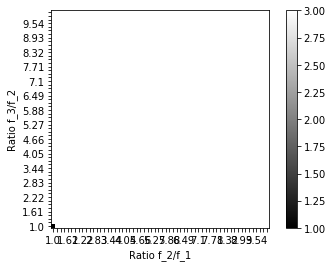

In [3]:
fig, ax = plt.subplots()

plt.imshow(n_IMFs.T, origin='lower', cmap='gray')
plt.xlabel('Ratio f_2/f_1')
plt.ylabel('Ratio f_3/f_2')
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2))
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2))
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.colorbar()
plt.show()

In [4]:
np.sum(n_IMFs != 3)

1

## Median instantaneous frequencies for each IMF for each frequency ratio
First a quick look at the median instantaneous frequencies for each IMF. This does not appear in the thesis.


### IMF 1: median Instantaneous frequency

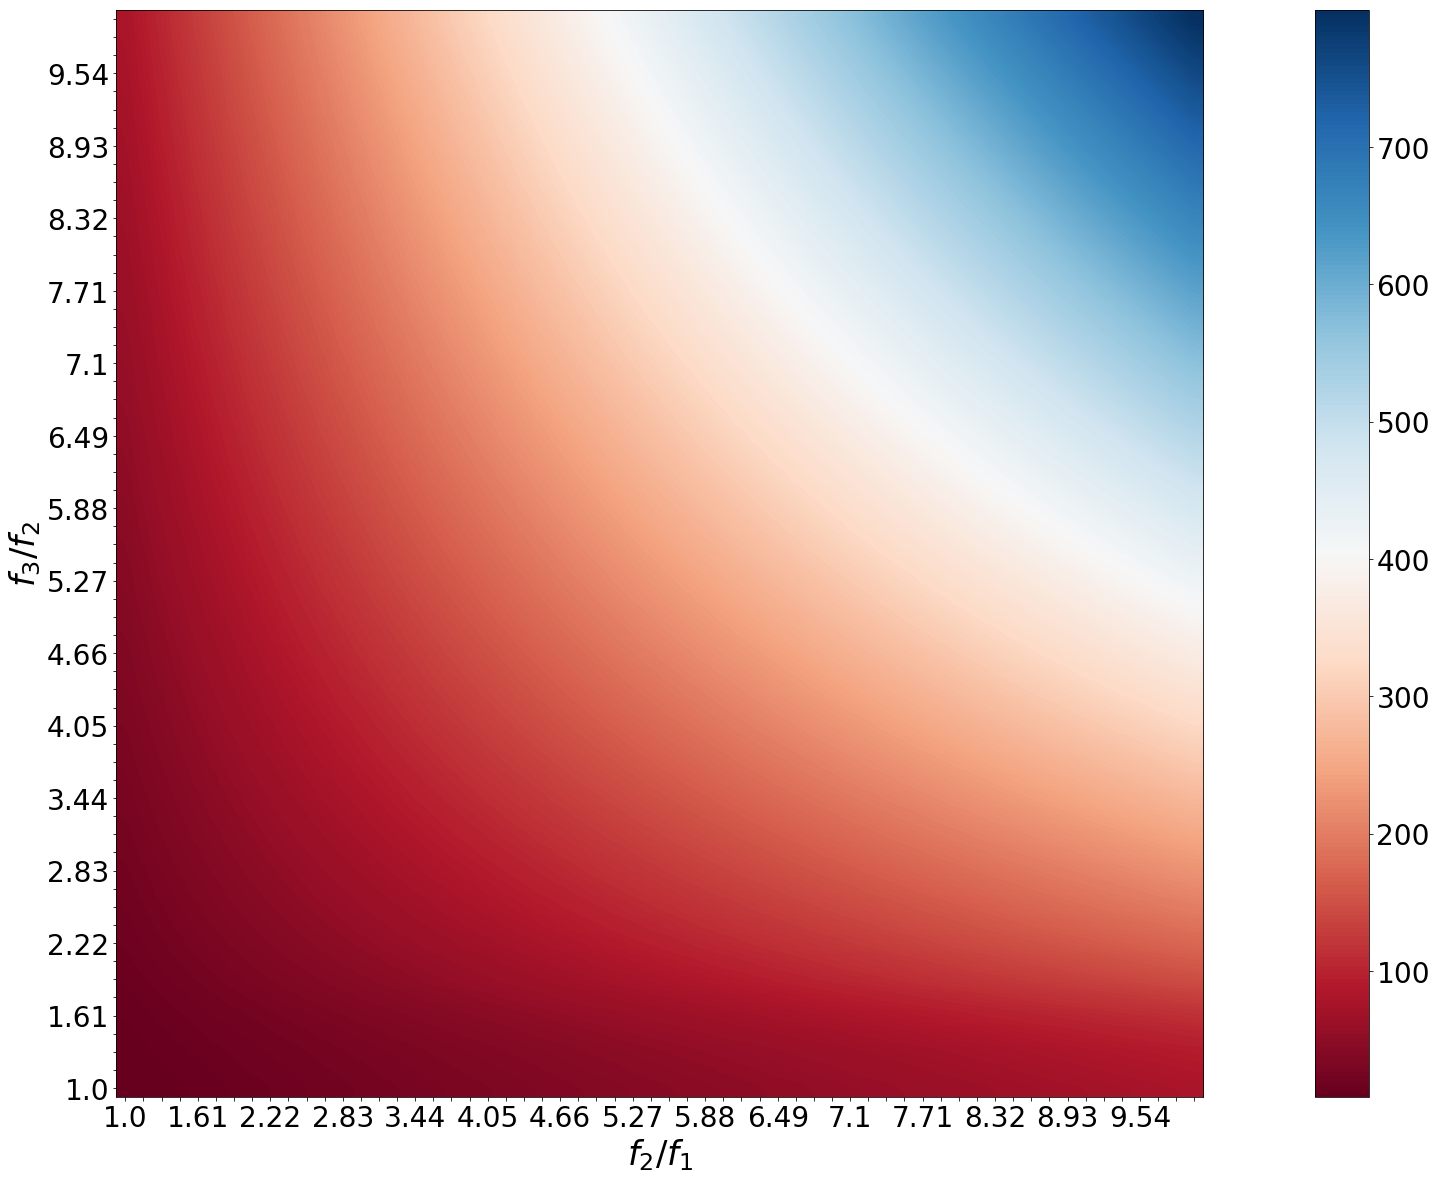

In [5]:
fig, ax = plt.subplots(figsize=(40,20))
plt.imshow(inst_freq_all[:,:,0].T, origin='lower', interpolation='gaussian', cmap='RdBu')#, vmin=5, vmax=12)
plt.xlabel('$f_2/f_1$', fontsize=34)
plt.ylabel('$f_3/f_2$', fontsize=34)
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2), fontsize=28)
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2), fontsize=28)
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=28)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.show()

### IMF 2: median Instantaneous frequency

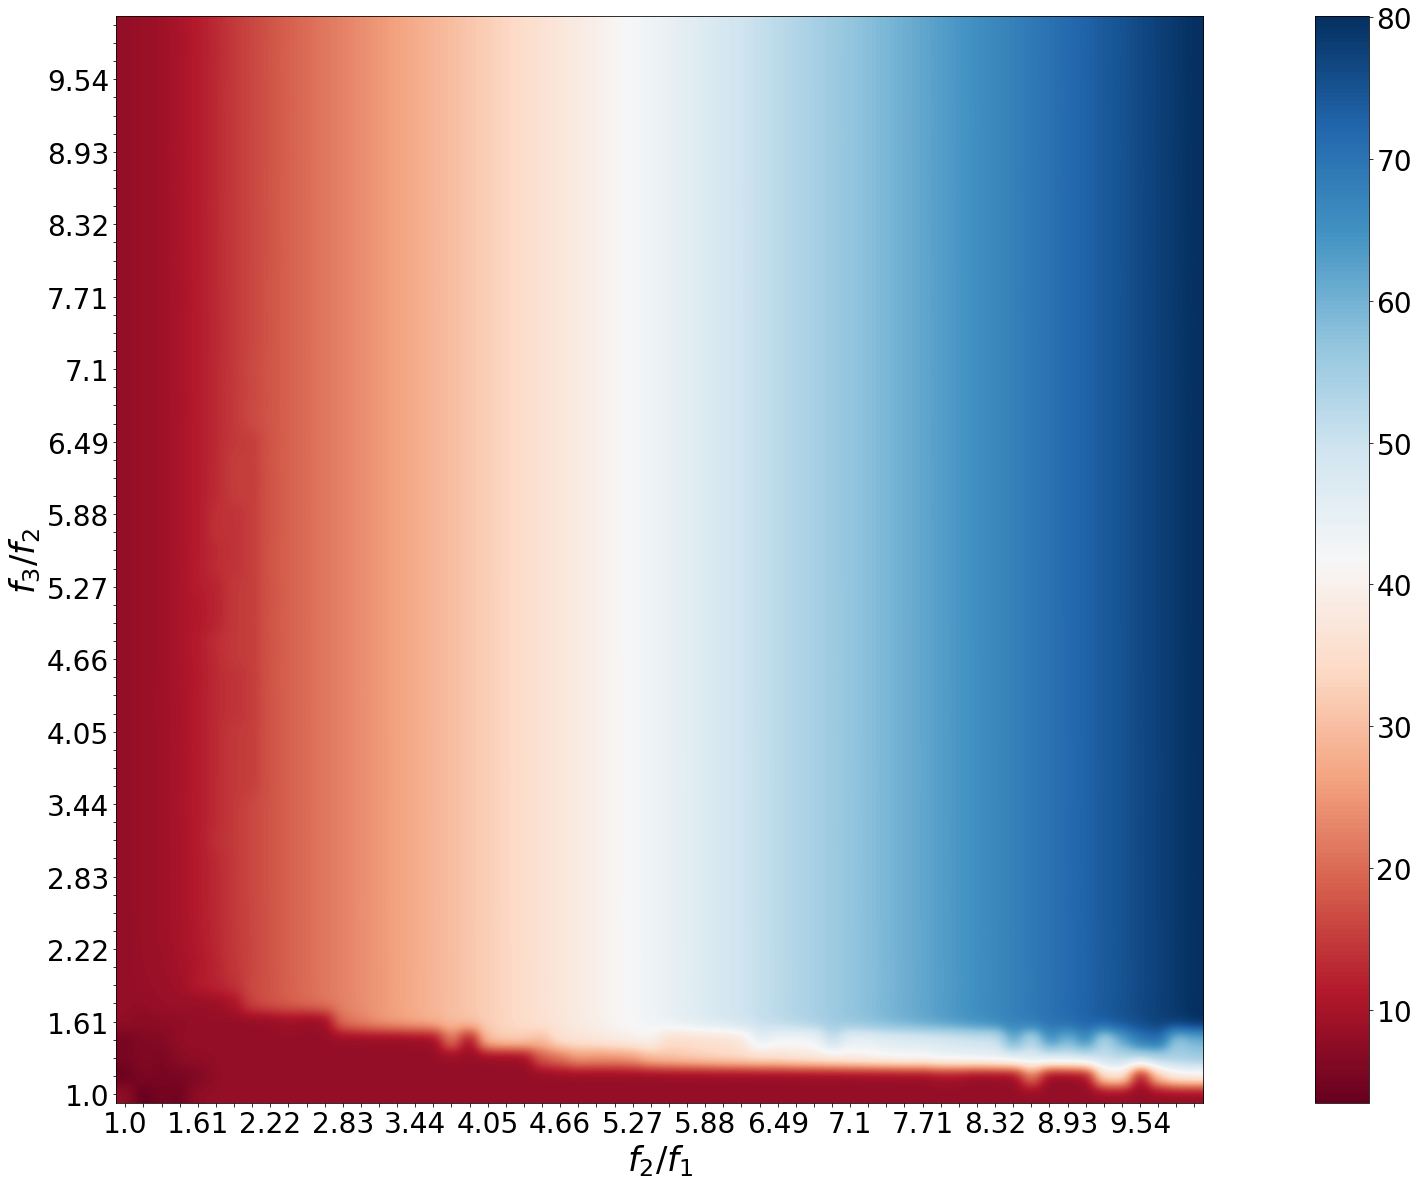

In [6]:
fig, ax = plt.subplots(figsize=(40,20))
plt.imshow(inst_freq_all[:,:,1].T, origin='lower', interpolation='gaussian', cmap='RdBu')#, vmin=5, vmax=12)
plt.xlabel('$f_2/f_1$', fontsize=34)
plt.ylabel('$f_3/f_2$', fontsize=34)
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2), fontsize=28)
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2), fontsize=28)
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=28)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.show()

### IMF 3: median Instantaneous frequency

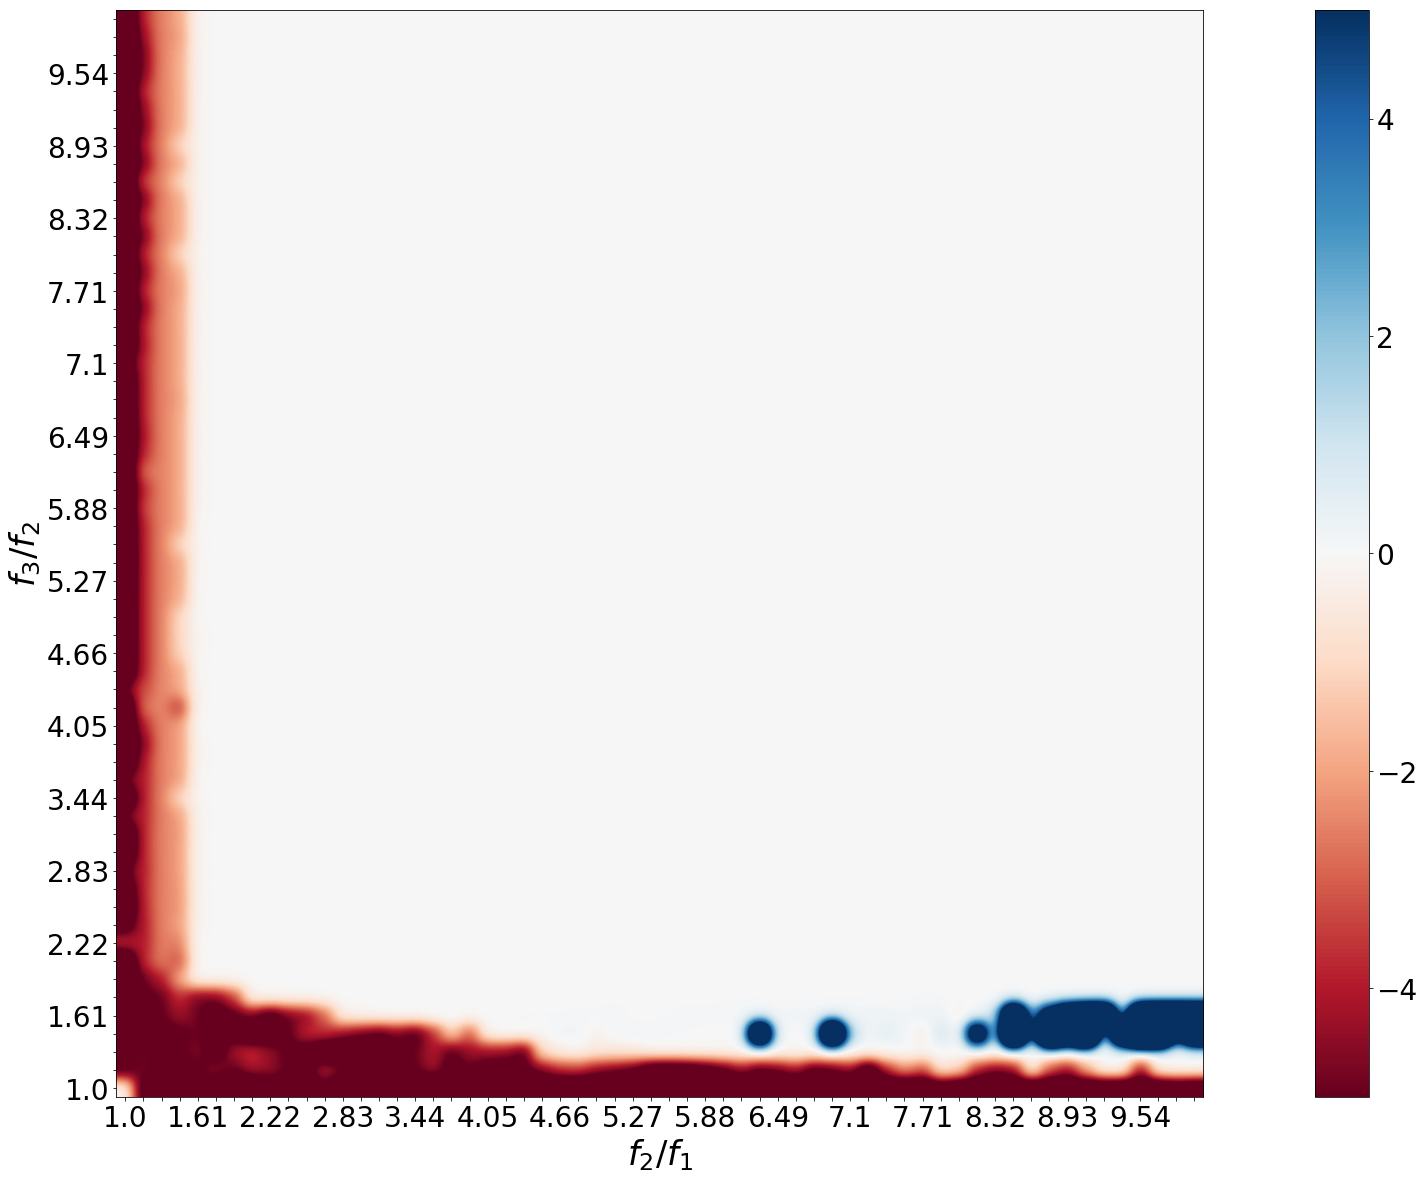

In [7]:
fig, ax = plt.subplots(figsize=(40,20))
plt.imshow(inst_freq_all[:,:,2].T - 8, origin='lower', interpolation='gaussian', cmap='RdBu', vmin=-5, vmax=5)#, vmin=5, vmax=12)
plt.xlabel('$f_2/f_1$', fontsize=34)
plt.ylabel('$f_3/f_2$', fontsize=34)
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2), fontsize=28)
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2), fontsize=28)
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=28)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.show()

## Squared correlation coefficient for each IMF with corresponding component
This part reproduces Figures 19 and 20. Given mode mixing when components are close in frequency, one must be careful when interpreting the results here. Instead of only comparing each component with the IMF that _should_ match, one should compare each component with all IMFs. Also it would be better to keep more than just 3 IMFs. We in the examples from in Chapter 4.3 that sometimes the 8 Hz component is split between IMF 3 and 4.

### IMF 1: correlation

In [8]:
# C_all[n_f_2_steps, n_f_3_steps, nIMF, nF]

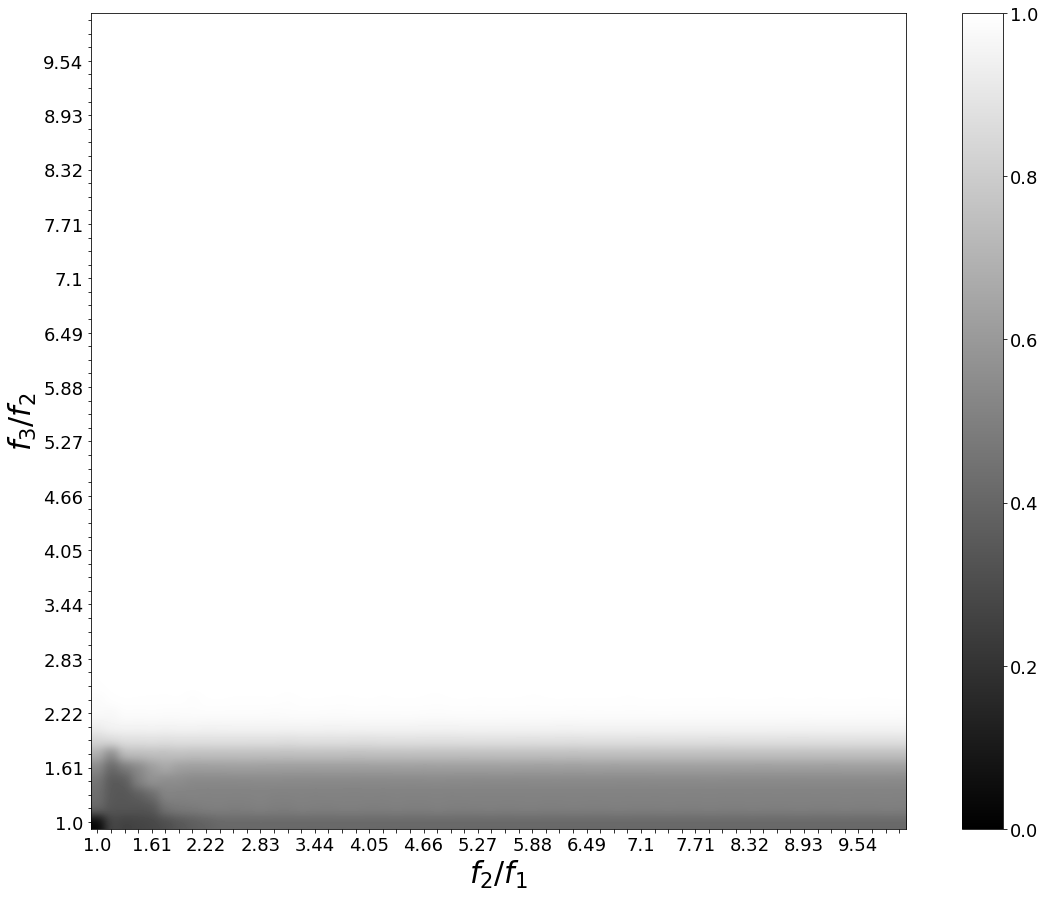

In [63]:
IMF = 0
COMP = 2
C_max = np.maximum(C_all[:,:,2,COMP].T**2, C_all[:,:,1,COMP].T**2, C_all[:,:,0,COMP].T**2)
C_sel = C_all[:,:,IMF,COMP].T**2

fig, ax = plt.subplots(figsize=(20,15))
plt.imshow(C_sel, origin='lower', cmap='gray', interpolation='gaussian', vmin=0., vmax=1.)
plt.xlabel('$f_2/f_1$', fontsize=30)
plt.ylabel('$f_3/f_2$', fontsize=30)
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2), fontsize=18)
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2), fontsize=18)
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.savefig('plots/ch4-3-1_imf1_comp_corr.pdf', bbox_inches = "tight")
        
plt.show()

### IMF 2: correlation

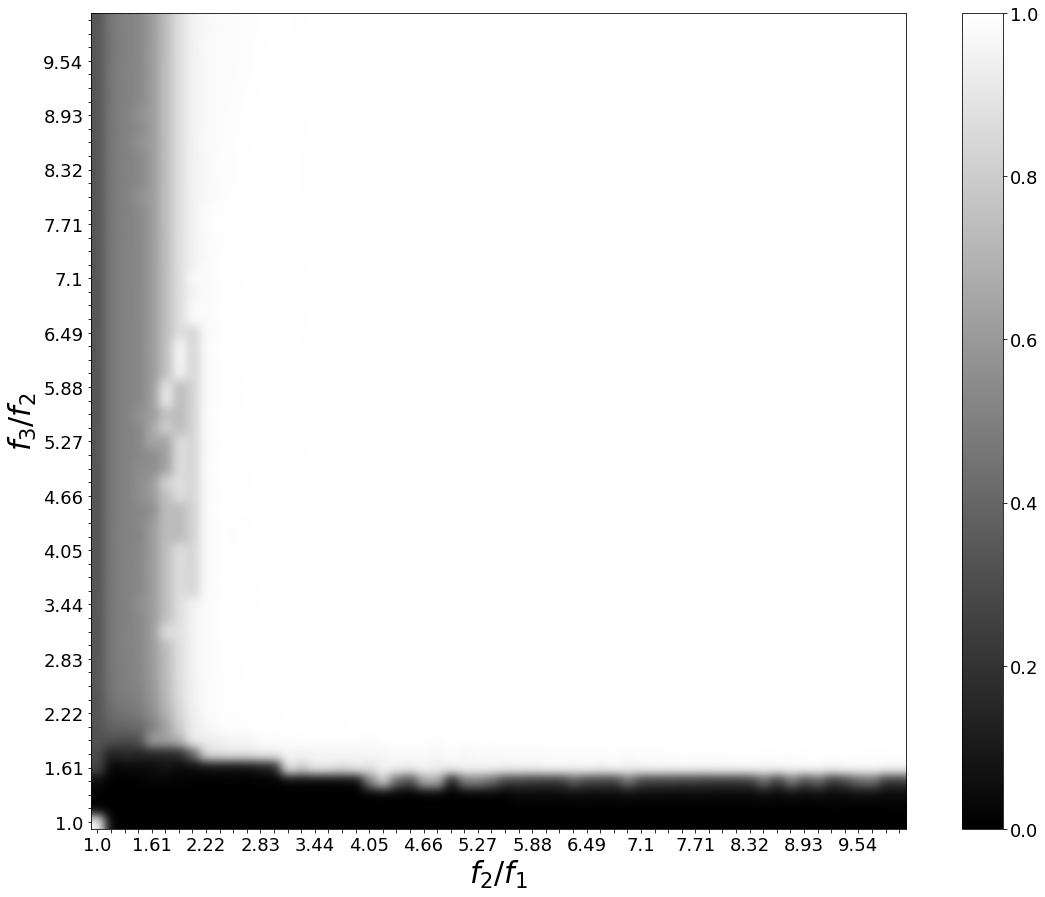

In [64]:
IMF = 1
COMP = 1
C_max = np.maximum(C_all[:,:,2,COMP].T**2, C_all[:,:,1,COMP].T**2, C_all[:,:,0,COMP].T**2)
C_sel = C_all[:,:,IMF,COMP].T**2

fig, ax = plt.subplots(figsize=(20,15))
plt.imshow(C_sel, origin='lower', cmap='gray', interpolation='gaussian', vmin=0., vmax=1.)
plt.xlabel('$f_2/f_1$', fontsize=30)
plt.ylabel('$f_3/f_2$', fontsize=30)
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2), fontsize=18)
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2), fontsize=18)
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.savefig('plots/ch4-3-2_imf2_comp_corr.pdf', bbox_inches = "tight")

plt.show()

### IMF 3: correlation

In [45]:
x1 = np.where(np.abs(ratios_12 - 2.875) < 0.1)[0][0]
x2 = np.where(np.abs(ratios_23 - 1.478) < 0.1)[0][0]

y1 = np.where(np.abs(ratios_12 - 9.5) < 0.1)[0][0]
y2 = np.where(np.abs(ratios_23 - 1.6184) < 0.1)[0][0]

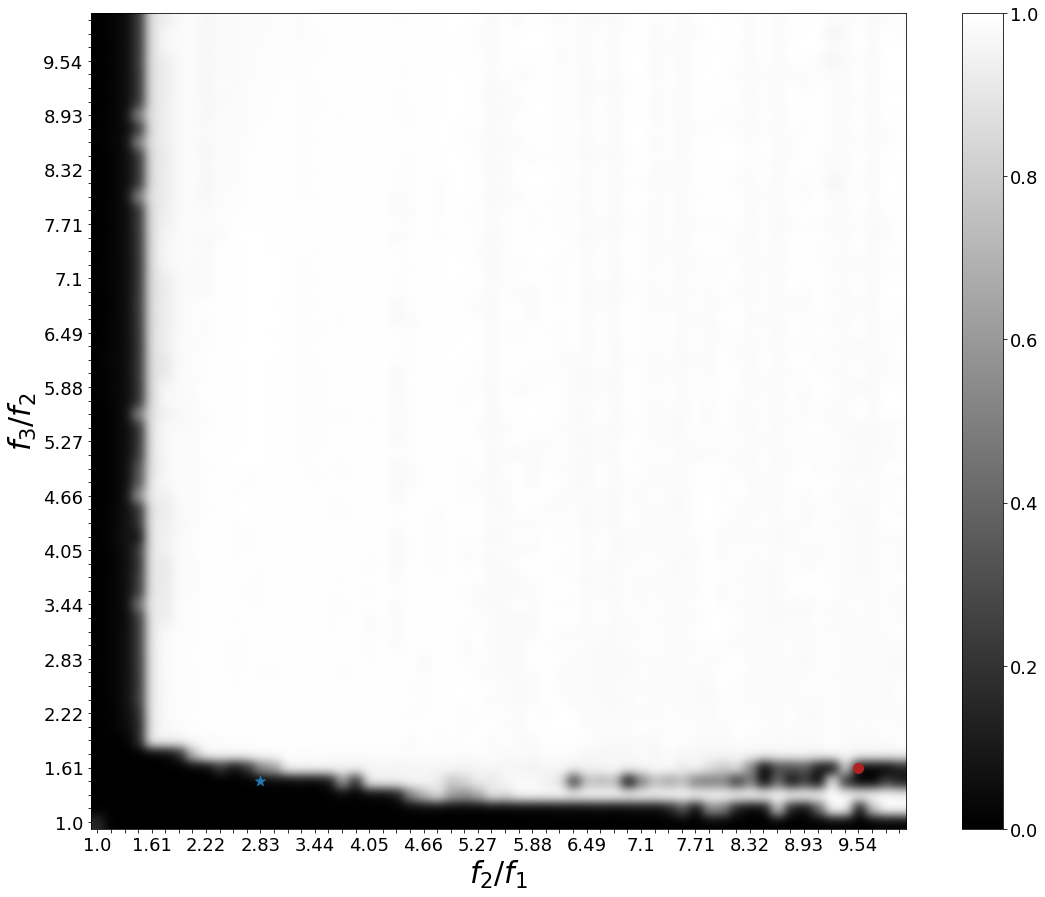

In [65]:
IMF = 2
COMP = 0
C_max = np.maximum(C_all[:,:,2,COMP].T**2, C_all[:,:,1,COMP].T**2, C_all[:,:,0,COMP].T**2)
C_sel = C_all[:,:,IMF,COMP].T**2

fig, ax = plt.subplots(figsize=(20,15))
plt.imshow(C_sel, origin='lower', cmap='gray', interpolation='gaussian', vmin=0., vmax=1.)
plt.xlabel('$f_2/f_1$', fontsize=30)
plt.ylabel('$f_3/f_2$', fontsize=30)
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2), fontsize=18)
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2), fontsize=18)
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

        
plt.scatter(x1, x2, marker='*', s=100)
plt.scatter(y1, y2, c='firebrick', s=100, marker='o')
        
plt.savefig('plots/ch4-3-3_imf3_comp_corr.pdf', bbox_inches = "tight")
        
plt.show()

### Correlation IMF 2 vs Comp 1

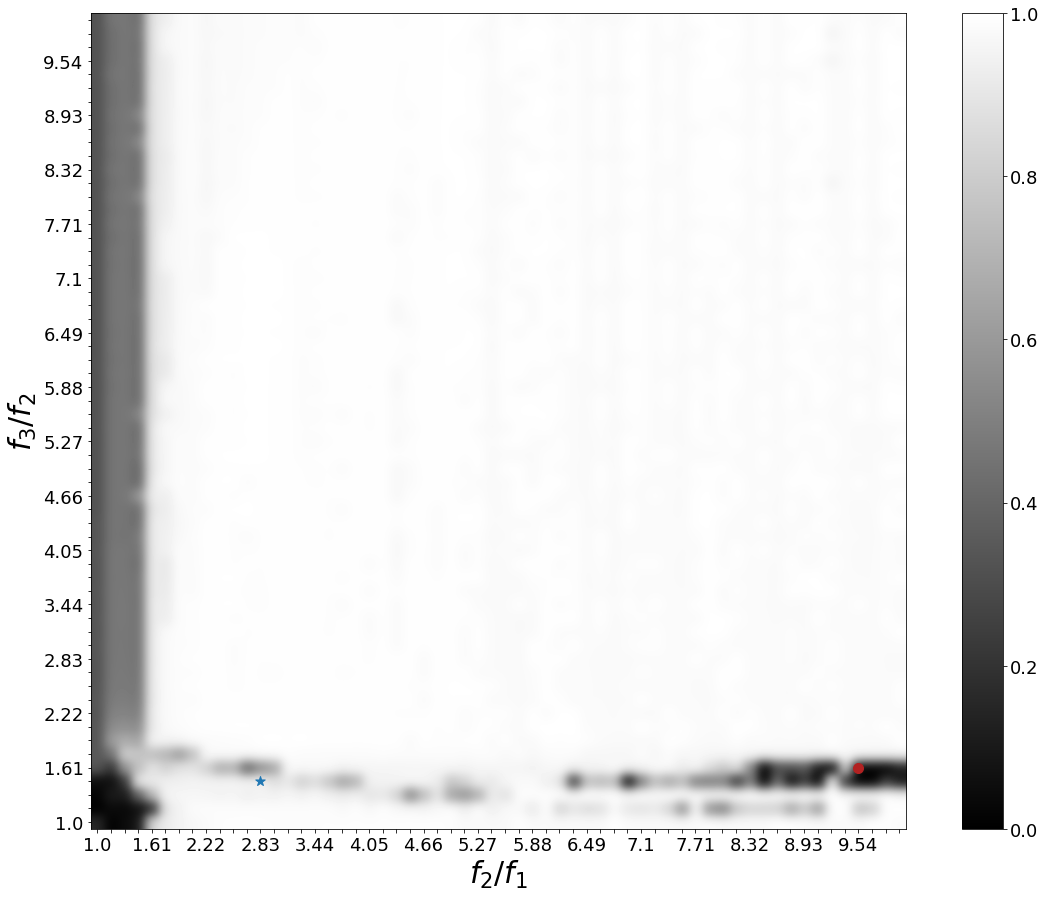

In [66]:
IMF = 2
COMP = 0
C_max = np.maximum(C_all[:,:,2,COMP].T**2, C_all[:,:,1,COMP].T**2, C_all[:,:,0,COMP].T**2)
C_sel = C_all[:,:,IMF,COMP].T**2

fig, ax = plt.subplots(figsize=(20,15))
plt.imshow(C_max, origin='lower', cmap='gray', interpolation='gaussian', vmin=0., vmax=1.)
plt.xlabel('$f_2/f_1$', fontsize=30)
plt.ylabel('$f_3/f_2$', fontsize=30)
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2), fontsize=18)
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2), fontsize=18)
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.scatter(x1, x2, marker='*', s=100)
plt.scatter(y1, y2, c='firebrick', s=100, marker='o')

plt.savefig('plots/ch4-3-4_imf3_comp_max_corr.pdf', bbox_inches = "tight")
        
plt.show()

## Instantaneous Frequency and Amplitude

The first two plots here correspond to Figure 21.

### IMF 1, frequency

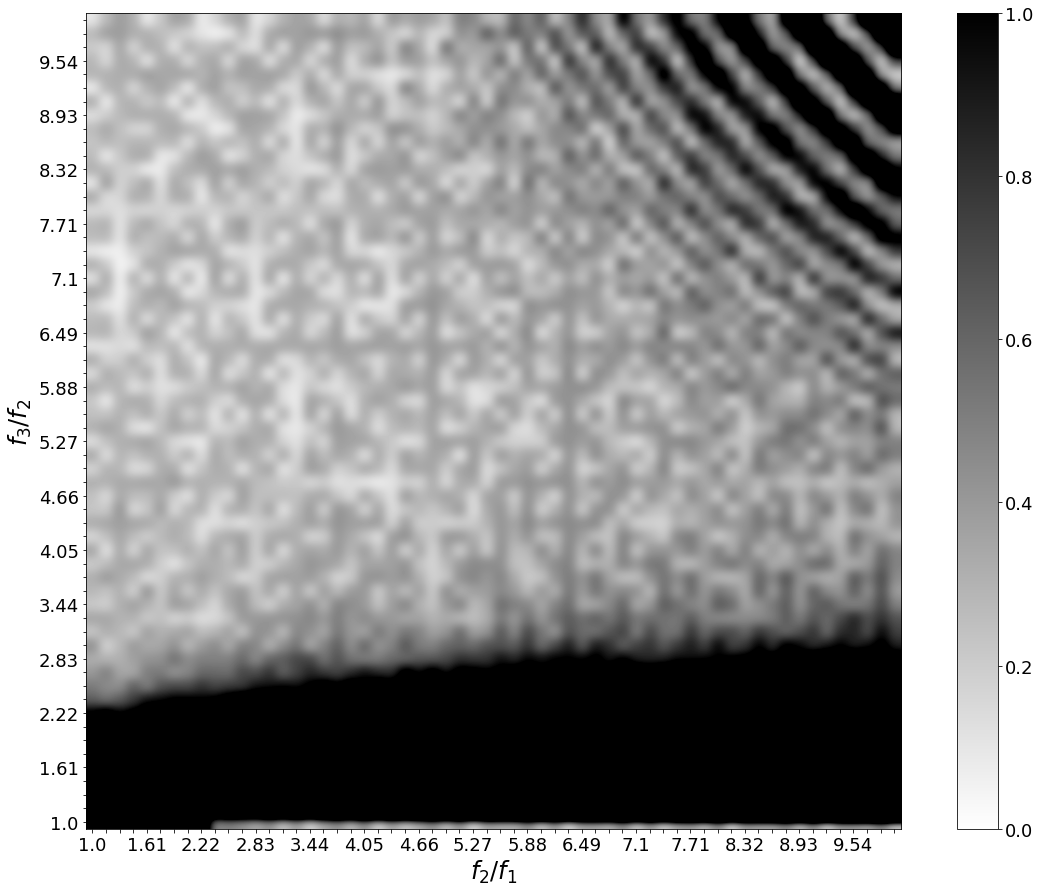

In [13]:
fig, ax = plt.subplots(figsize=(20,15))
plt.imshow(IF_all[:,:,0].T, origin='lower', cmap='gray_r', interpolation='gaussian', vmin=0, vmax=1.)
plt.xlabel('$f_2/f_1$', fontsize=24)
plt.ylabel('$f_3/f_2$', fontsize=24)
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2), fontsize=18)
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2), fontsize=18)
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.savefig('plots/ch4-3-4_IF_all_1.pdf', bbox_inches = "tight")
        
plt.show()

### IMF 1 with boundaries cut off

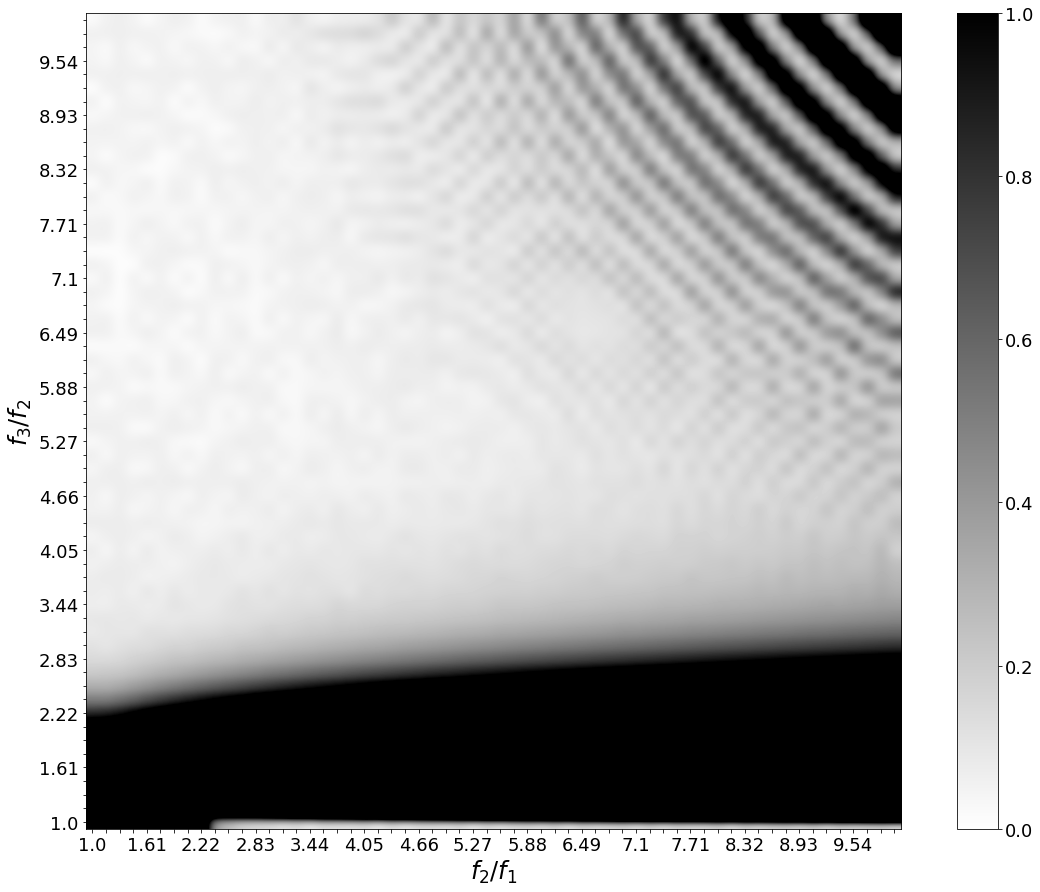

In [14]:
fig, ax = plt.subplots(figsize=(20,15))
plt.imshow(IF_nb_all[:,:,0].T, origin='lower', cmap='gray_r', interpolation='gaussian', vmin=0., vmax=1.)
plt.xlabel('$f_2/f_1$', fontsize=24)
plt.ylabel('$f_3/f_2$', fontsize=24)
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2), fontsize=18)
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2), fontsize=18)
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.savefig('plots/ch4-3-5_IF_nb_all_1.pdf', bbox_inches = "tight")
    
plt.show()

### IMF 1, amplitude

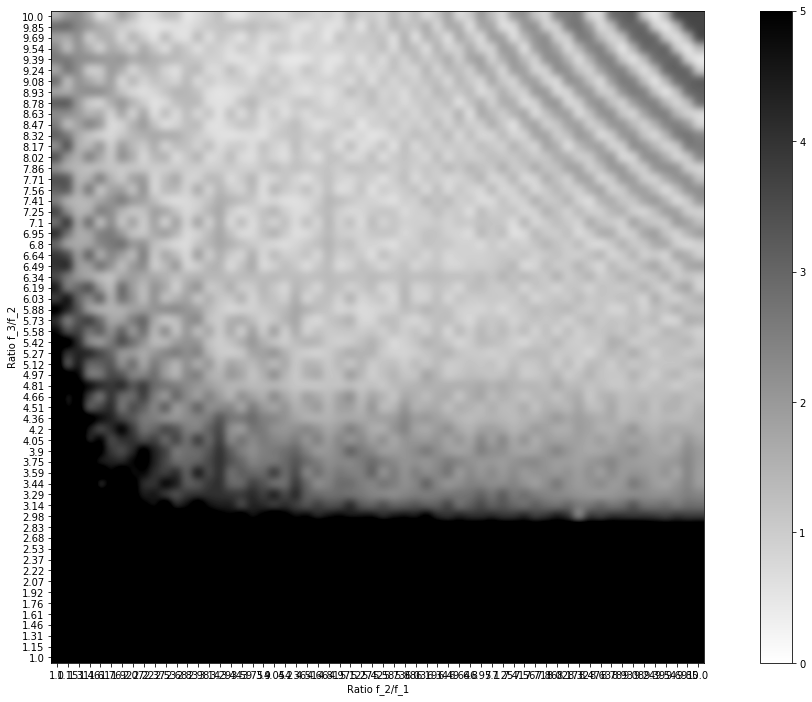

In [211]:
plt.figure(figsize=(20,12))
plt.imshow(IA_all[:,:,0].T, origin='lower', interpolation='gaussian', cmap='gray_r', vmin=0., vmax=0.005*max_amp)
plt.xlabel('Ratio f_2/f_1')
plt.ylabel('Ratio f_3/f_2')
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2))
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2))
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
plt.colorbar()
plt.show()

### IMF 1, amplitude, no boundaries

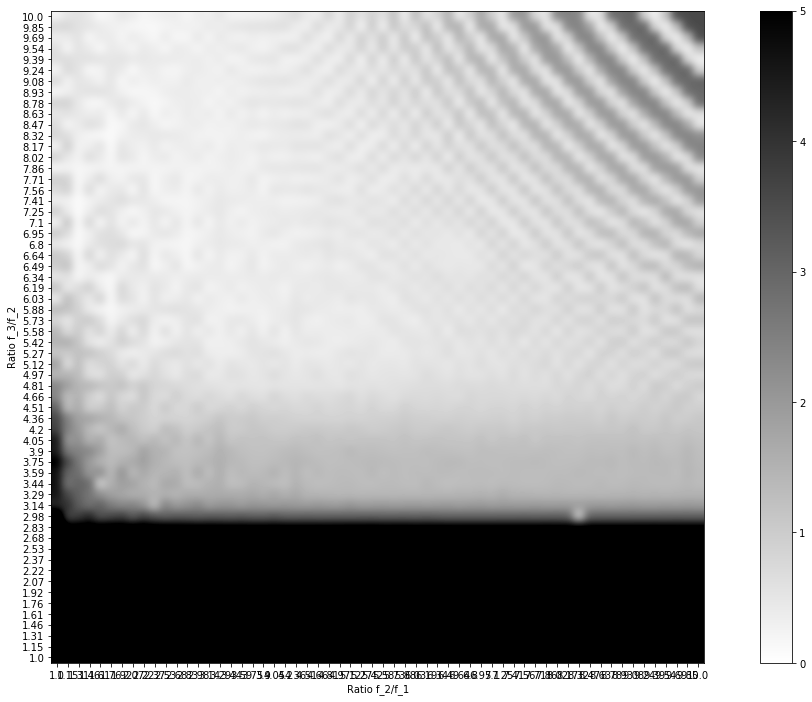

In [129]:
plt.figure(figsize=(20,12))
plt.imshow(IA_nb_all[:,:,0].T, origin='lower', cmap='gray_r', interpolation='gaussian', vmin=0., vmax=0.005*max_amp)
plt.xlabel('Ratio f_2/f_1')
plt.ylabel('Ratio f_3/f_2')
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2))
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2))
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
plt.colorbar()
plt.show()

### Compute concentration of correlation matrix on diagonal

In [212]:
diag_conc = np.zeros((n_f_2_steps, n_f_3_steps))
for k in range(n_f_2_steps):
    for j in range(n_f_3_steps):
            sum_diag = np.sum(np.abs(np.diag(np.fliplr(C_all[k,j,:,:]))))
            sum_off_diag = np.sum(C_all[k,j,:,:]) - sum_diag
            diag_conc[k,j] = sum_diag/(sum_diag + sum_off_diag)

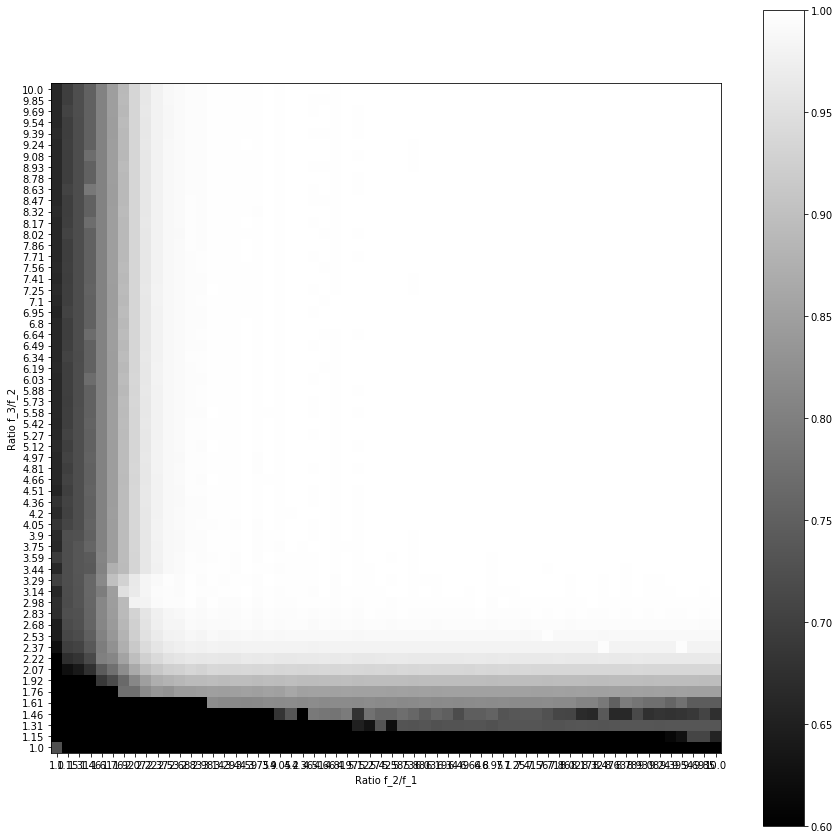

In [213]:
plt.figure(figsize=(15,15))
plt.imshow(diag_conc.T, origin='lower', cmap='gray', vmin=0.6, vmax=1.0)
plt.xlabel('Ratio f_2/f_1')
plt.ylabel('Ratio f_3/f_2')
plt.xticks(np.linspace(0,n_f_2_steps,n_f_2_steps+1), np.round(ratios_12, 2))
plt.yticks(np.linspace(0,n_f_3_steps,n_f_3_steps+1), np.round(ratios_23, 2))
plt.xlim(-0.5, n_f_2_steps-0.5)
plt.ylim(-0.5, n_f_3_steps-0.5)
plt.colorbar()
plt.show()

### Exploration

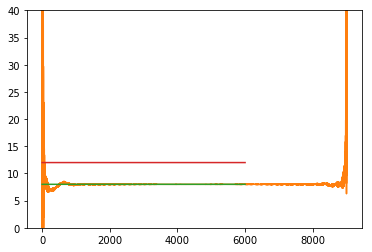

In [422]:
plt.plot(instantaneous_frequency.T)
plt.plot(8*np.ones(shape=(6000,)))
plt.plot(F[0][1]*np.ones(shape=(6000,)))
plt.ylim(0,40)
plt.show()

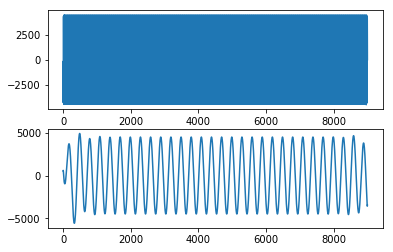

In [465]:
plt.subplot(211)
plt.plot(imfs[0,:])
plt.subplot(212)
plt.plot(imfs[1,:])
plt.show()

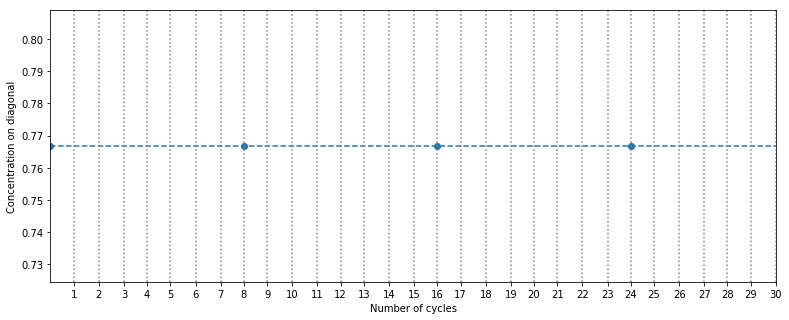

In [129]:
plt.figure(figsize=(13,5))
plt.plot(diag_conc[0,:], '--o')
plt.xlim(0, max_length)
xcoords = np.round(np.linspace(cycle_length, max_length, int(max_length/cycle_length)), 2)
plt.xticks(xcoords, np.arange(1,len(xcoords)+1))
for xc in xcoords:
    plt.axvline(x=xc, linestyle='dotted', color='grey')
plt.xlabel('Number of cycles')
plt.ylabel('Concentration on diagonal')
plt.show()

### Print median frequencies of IMFs

In [202]:
np.set_printoptions(suppress=True)
f_m = np.round(np.median(instantaneous_frequency,1),2)
for i in range(len(f_m)):
    print('IMF ' + str(i+1) + ': ' + str(f_m[i]))

IMF 1: 16.71
IMF 2: 8.0


### Plot data and IMFs

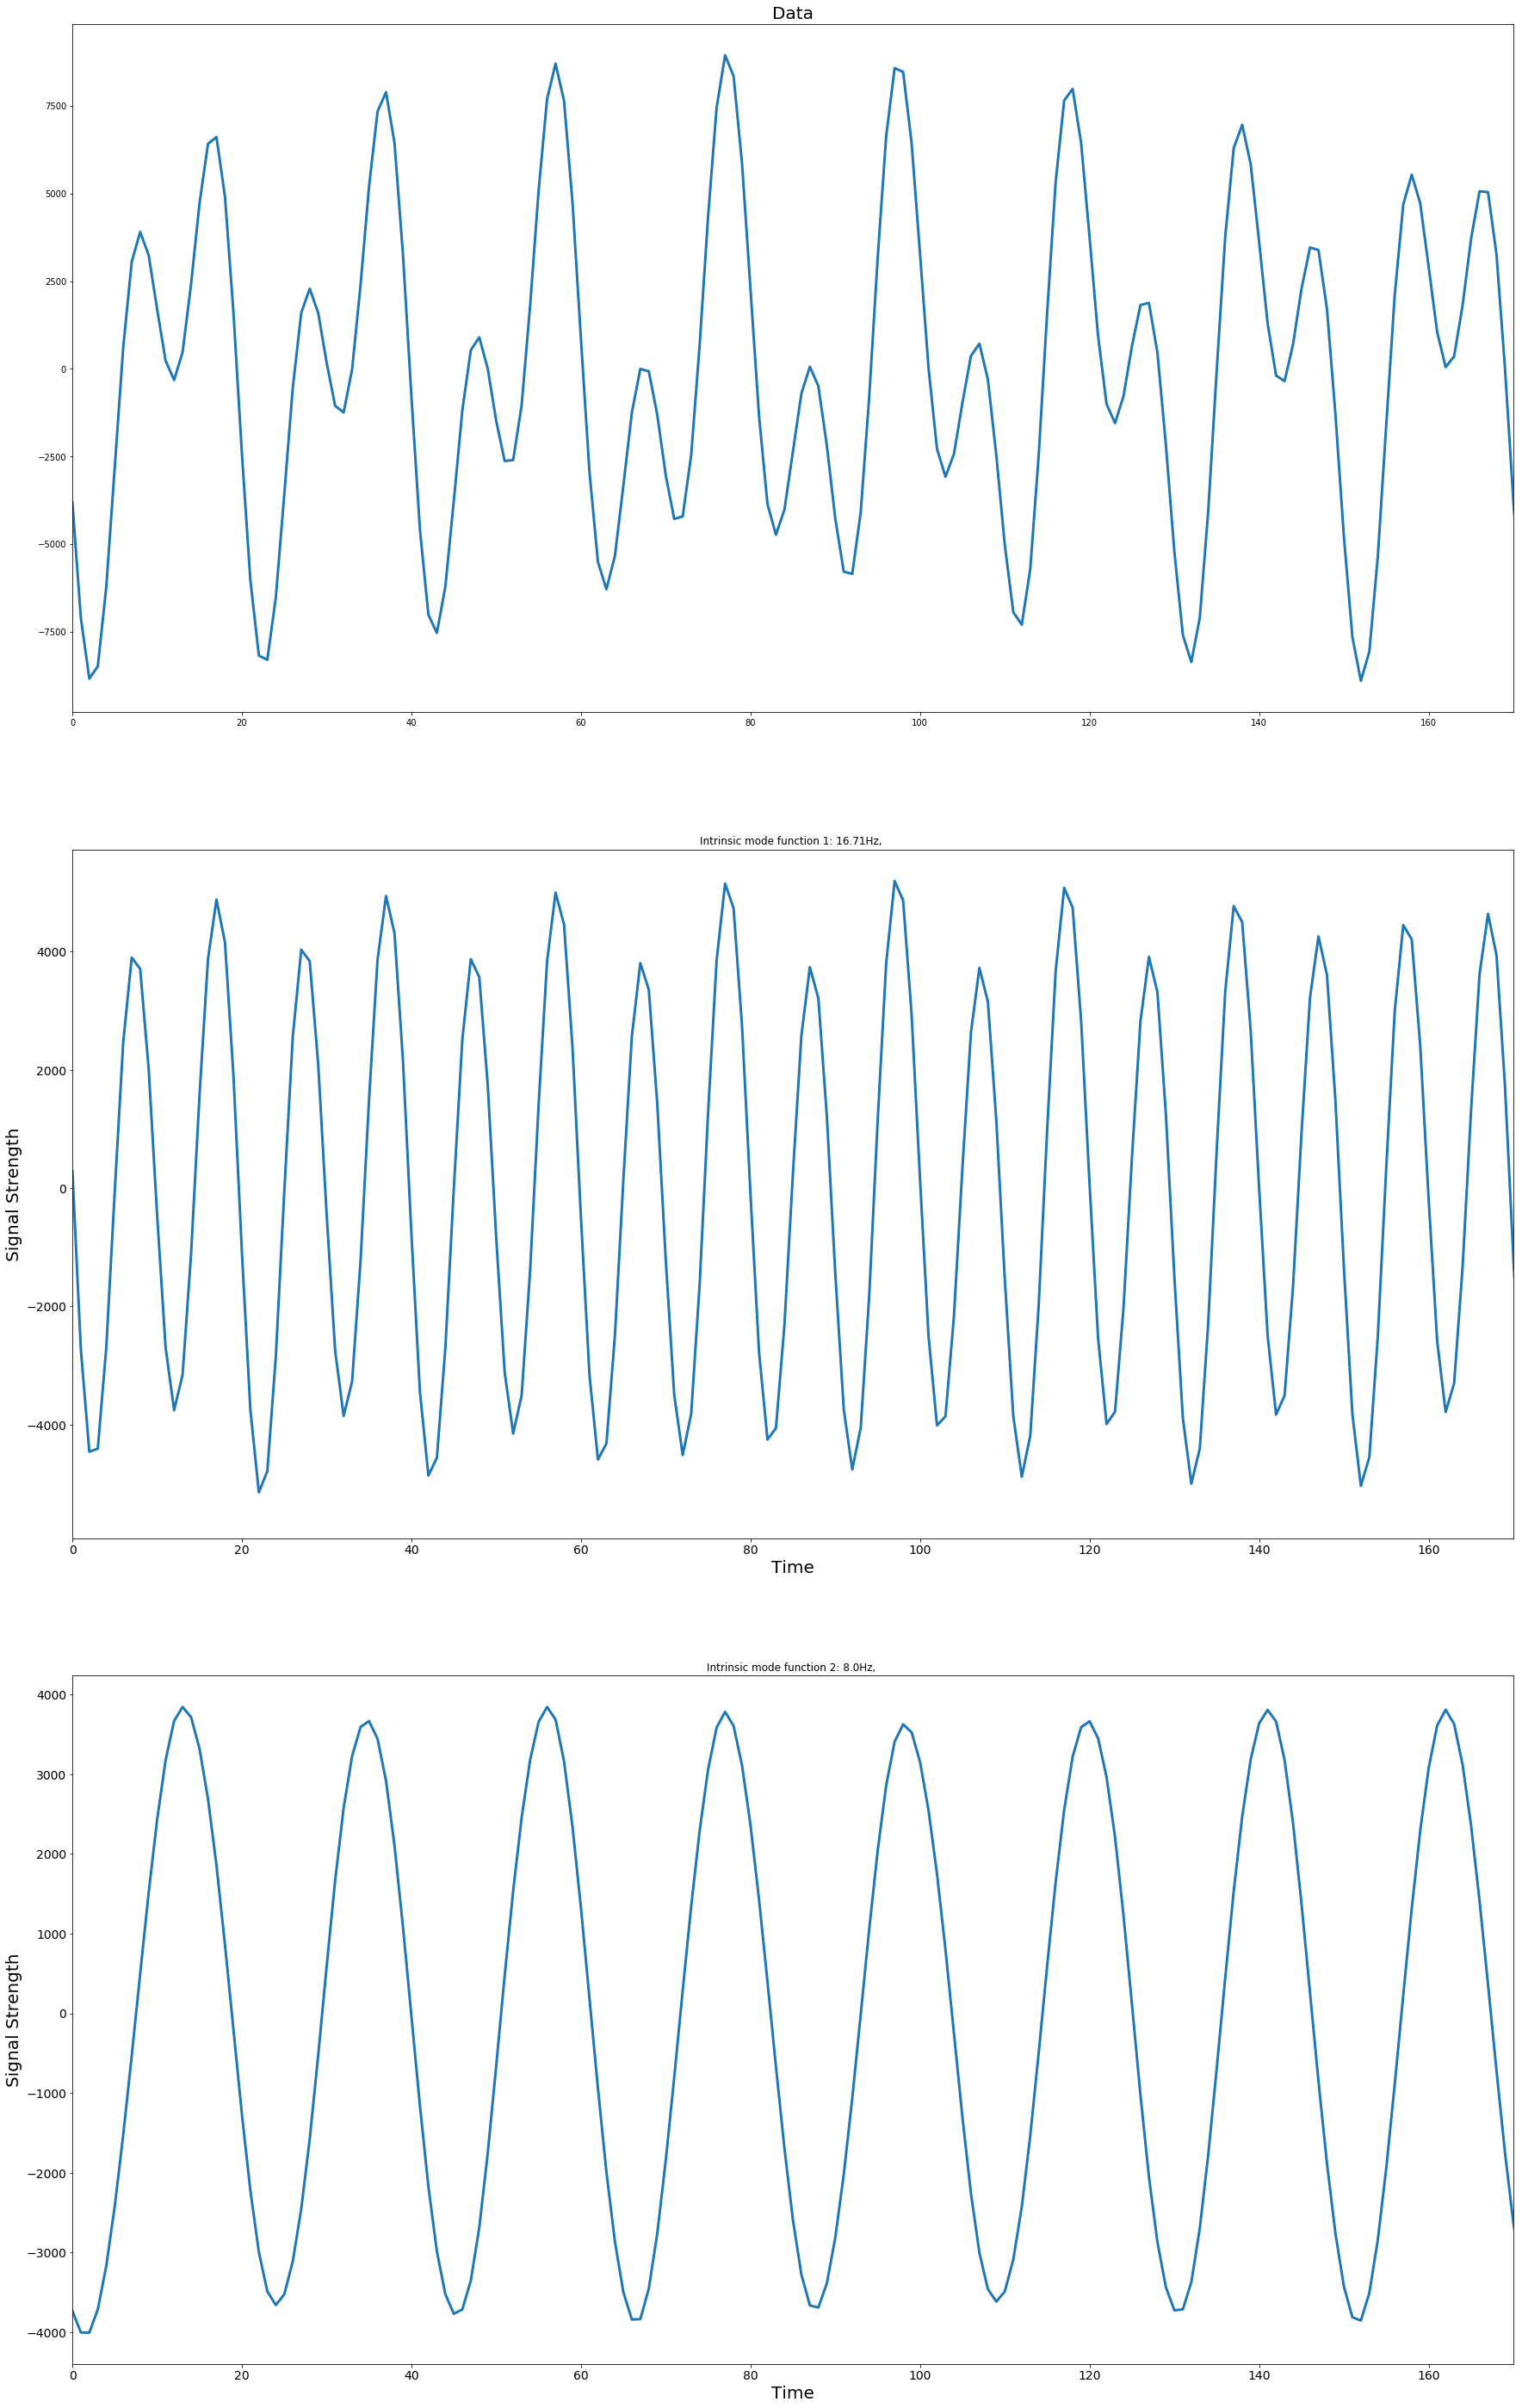

In [203]:
plt.figure(figsize=(30,50))
plt.subplot(nIMF+1,1,1)
plt.plot(x, linewidth=3)
plt.xlim(0, fs)
plt.title('Data', fontsize=20)
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(imfs[ii-1,:], linewidth=3)
    #plt.plot(C[-ii,:], '--k',linewidth=2)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz, '
             )#'Actual: ' + str(f[-ii]), fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Signal Strength', fontsize=20)
    plt.xlim(0, fs)
plt.show()

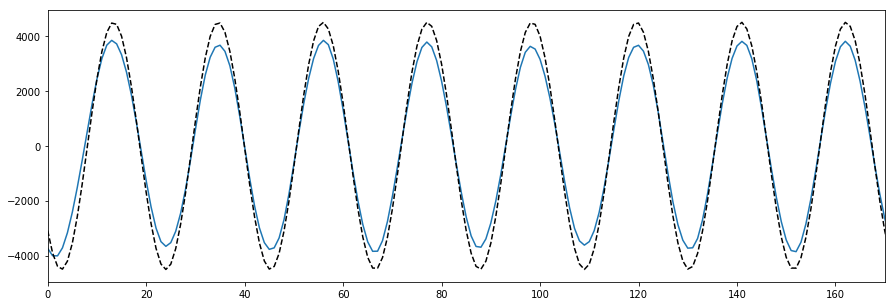

In [204]:
plt.figure(figsize=(15,5))
plt.plot(np.sum(imfs[(f_m > 5.) & (f_m < 12.),:], axis=0))
plt.plot(C[0,:], '--k')
plt.xlim(0, fs)
plt.show()

### Plot instantaneous frequency of IMFs

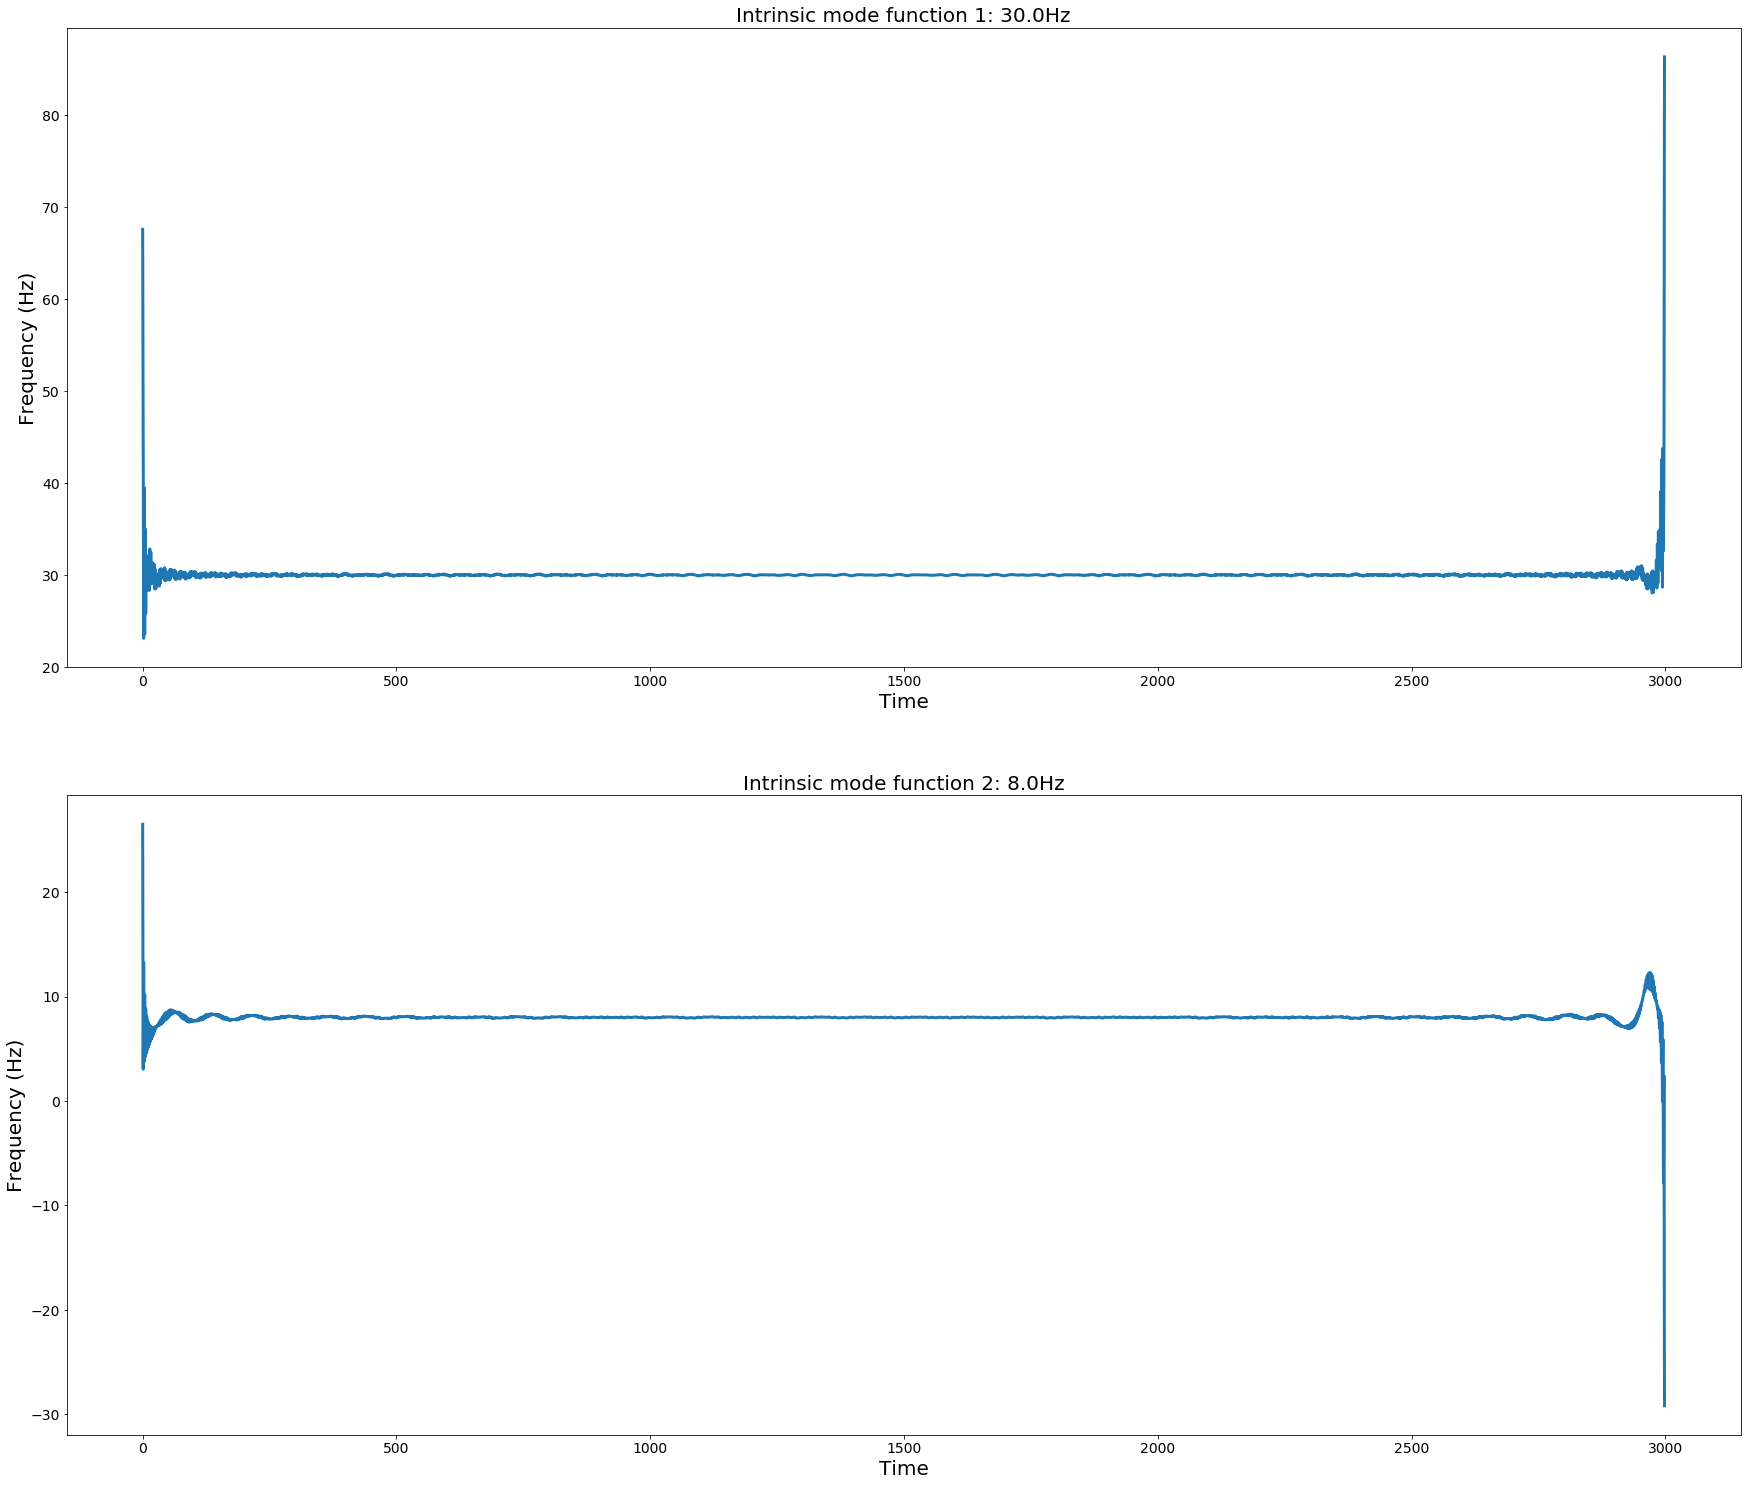

In [27]:
plt.figure(figsize=(30,40))
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(instantaneous_frequency[ii-1,:], linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Frequency (Hz)', fontsize=20)
    #plt.xlim(0, fs)
plt.show()

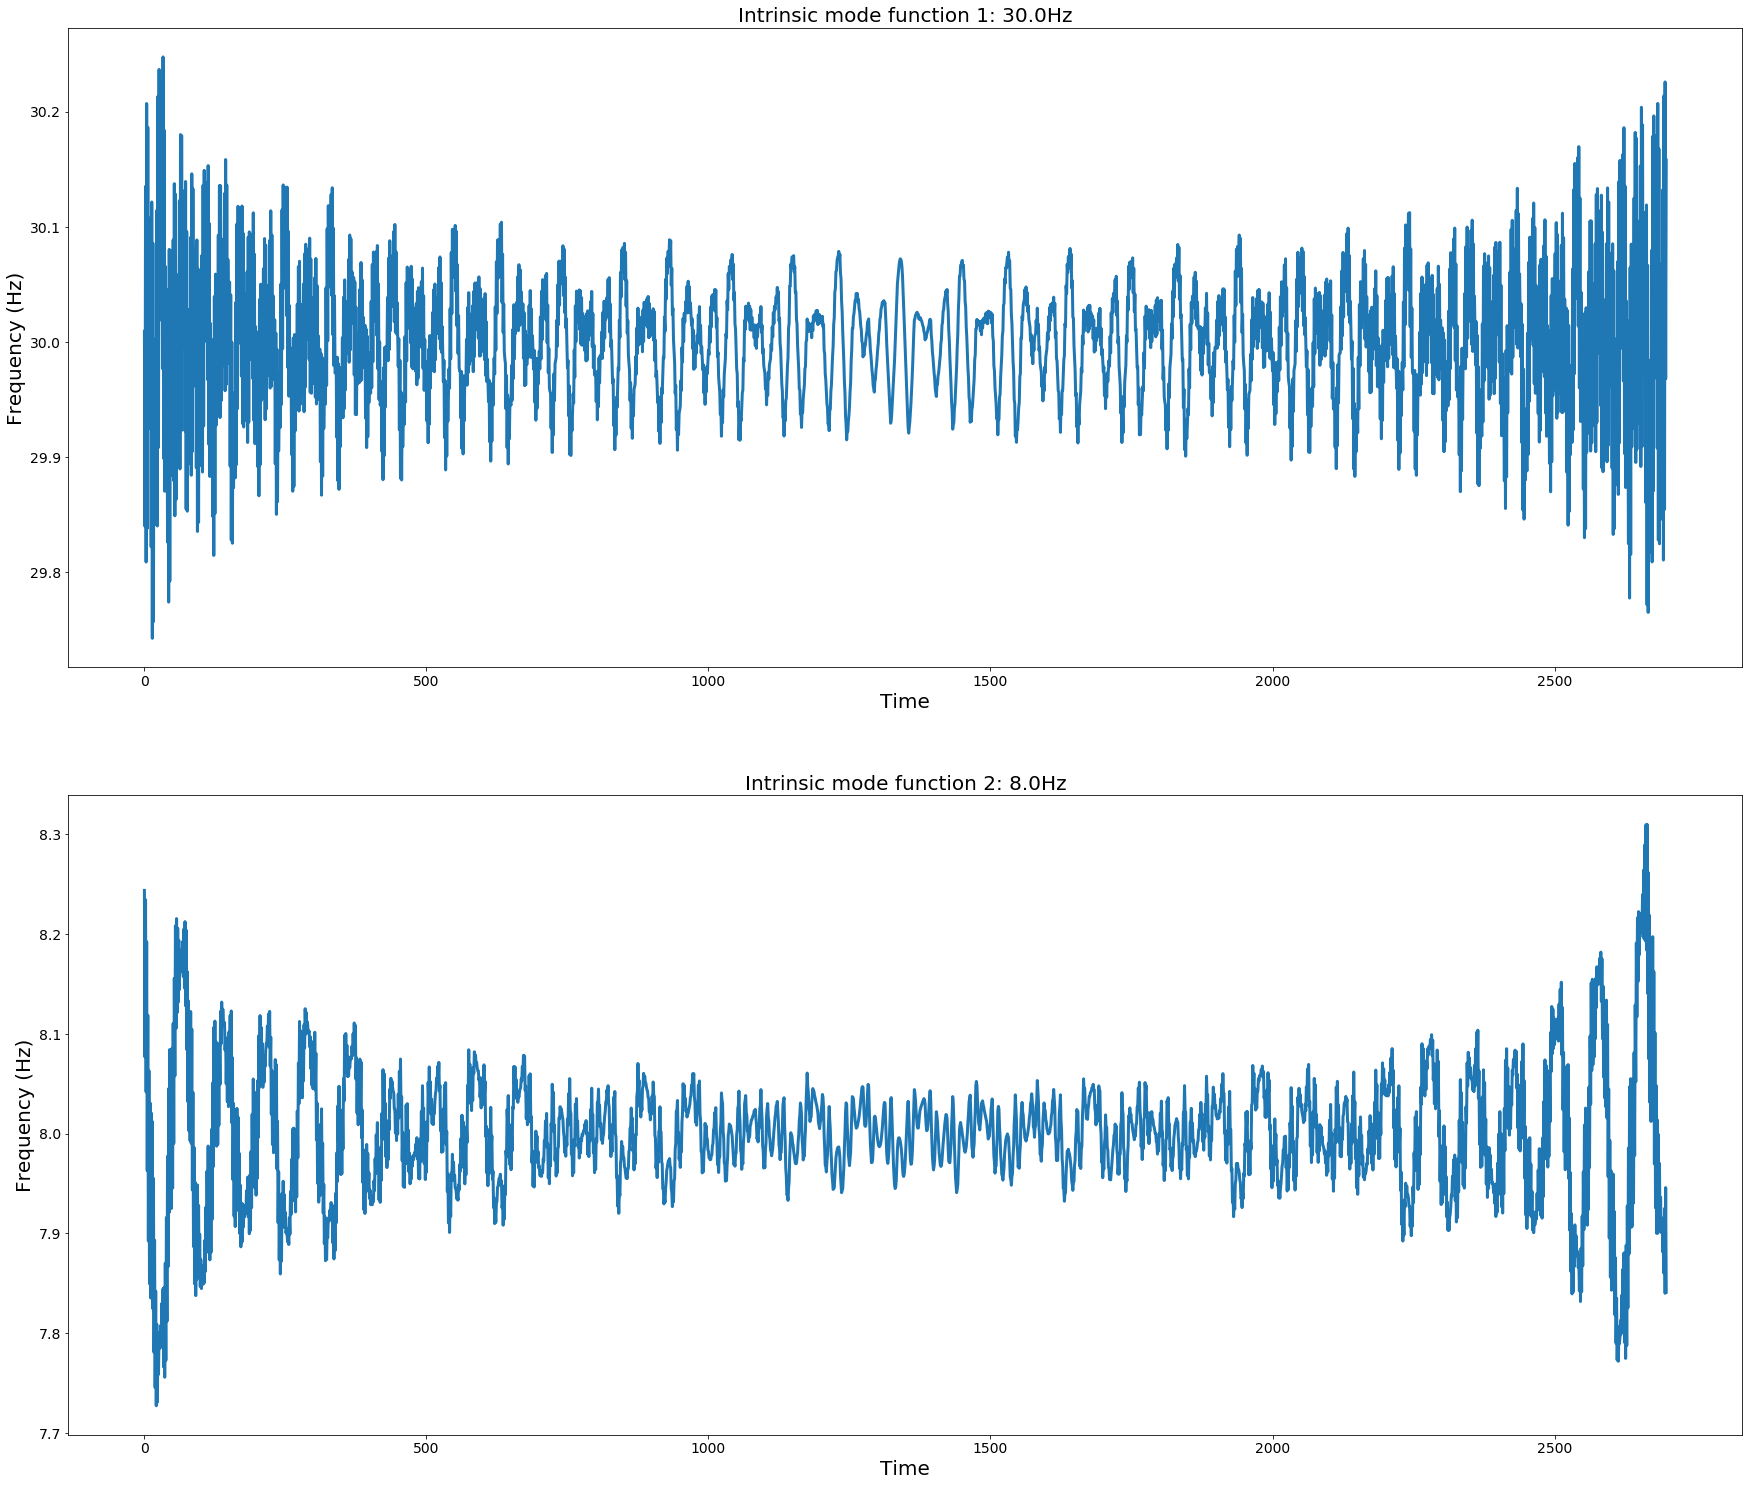

In [28]:
plt.figure(figsize=(30,40))
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(instantaneous_frequency[ii-1,int(nT/20):int(-nT/20)], linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Frequency (Hz)', fontsize=20)
    #plt.xlim(0, fs)
plt.show()